Title : Text Classification for Detecting Spam Message

Tujuan : Membuat model yang dapat digunakan untuk mengotomatisasi aplikasi perpesanan dalam mengategorikan suatu pesan spam atau bukan

Dataset : https://www.kaggle.com/uciml/sms-spam-collection-dataset

# 0. Import Library

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import pandas as pd
import numpy as np
import re 
import nltk 
nltk.download('punkt')
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold


from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
import matplotlib.patches as mpatches

!pip install nltk
!pip install autocorrect

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 622 kB 3.6 MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.6.0-py3-none-any.whl size=622249 sha256=0c0ce6e5fb04d0ee04684d0bc14c186c1264e6495feda29be24320cf0493306e
  Stored in directory: /root/.cache/pip/wheels/fa/ce/aa/bc894efbe0541ce91dea21561d01d319783986d9787a8e9f58
Successfully built autocorrect


# 1. Business Understanding

Tujuan : Membuat model yang dapat digunakan untuk mengotomatisasi aplikasi perpesanan dalam mengategorikan suatu pesan spam atau bukan.

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=15XEikcGun8zVFiM0RI-IfCg859EkxfgL' -O spam.csv

--2021-12-03 01:46:49--  https://docs.google.com/uc?export=download&id=15XEikcGun8zVFiM0RI-IfCg859EkxfgL
Resolving docs.google.com (docs.google.com)... 108.177.125.138, 108.177.125.100, 108.177.125.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.125.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-b4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/du4pavg0jpr9jmtcaar7c6nfa6pno229/1638495975000/17539190491766931577/*/15XEikcGun8zVFiM0RI-IfCg859EkxfgL?e=download [following]
--2021-12-03 01:46:50--  https://doc-0c-b4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/du4pavg0jpr9jmtcaar7c6nfa6pno229/1638495975000/17539190491766931577/*/15XEikcGun8zVFiM0RI-IfCg859EkxfgL?e=download
Resolving doc-0c-b4-docs.googleusercontent.com (doc-0c-b4-docs.googleusercontent.com)... 74.125.203.132, 2404:6800:4008:c03::84
Connecting to doc-0c-b4-docs.googleusercontent.com (doc-0c-

#2. Data Understanding

***Interpretasi visualisasi dibawah ini***

In [ ]:
#Load Data
df = pd.read_csv("/content/spam.csv",encoding = "ISO-8859-1")
df = df[["v1","v2"]]

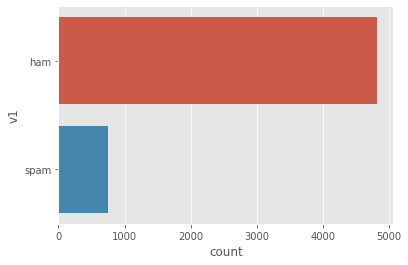

In [ ]:
#Sebaran Ham dan Spam
sns.countplot(y="v1",data=df)

In [ ]:
#Melihat Sebagian Data
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
data = df
data["No_of_Characters"] = data["v2"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["v2"]), axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["v2"]), axis=1).apply(len)

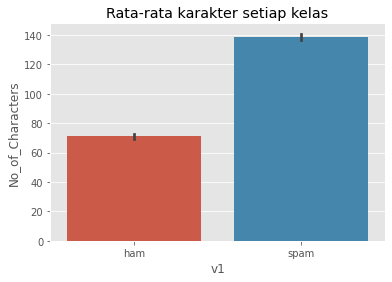

In [ ]:
#Average char by Class
sns.barplot(y=data["No_of_Characters"].iloc[:],x =data['v1'].iloc[:])

plt.title("Rata-rata karakter setiap kelas")
# Show the plot
plt.show()

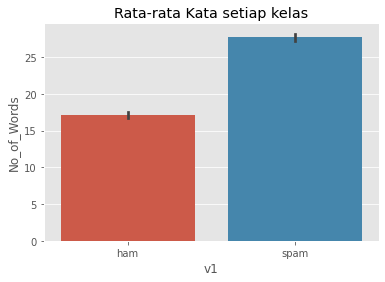

In [ ]:
#Average Word by Class
sns.barplot(y=data["No_of_Words"].iloc[:],x =data['v1'].iloc[:])

plt.title("Rata-rata Kata setiap kelas")
# Show the plot
plt.show()

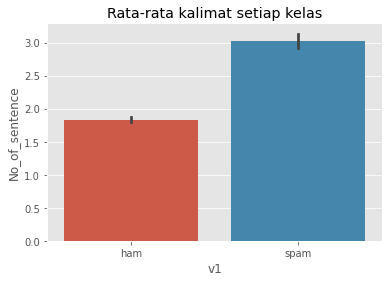

In [ ]:
#Average sentence by Class
sns.barplot(y=data["No_of_sentence"].iloc[:],x =data['v1'].iloc[:])

plt.title("Rata-rata kalimat setiap kelas")
# Show the plot
plt.show()

# 3. Data Preparation

* Removing nois (symbol, numeric, etc) and Lowering Case
* Spelling Correction [autocorrect]
* Removing Stopword
* Removing word with one char (I, u,)
* Lemmatization
* Label Encoder
* Tfidf




In [ ]:
# Removing noise
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

data["Clean_Text"] = data["v2"].apply(Clean)

In [ ]:
# Spelling correction
from autocorrect import Speller
spell = Speller(lang='en')

correct = []
for x in data["Clean_Text"] :
  x = spell(x)
  correct.append(x)

data["Clean_Text"] = np.array(correct)

In [ ]:
#Removing stopword
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer

data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    sentence = TreebankWordDetokenizer().detokenize(filtered_text)
    return sentence

data["Clean_Text"] = data["Tokenize_Text"].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Removing word with one char (I, u,)
def del_one_char(input):
  s = ' '.join( [w for w in input.split() if len(w)>1] )
  return s

data["Clean_Text"] = data["Clean_Text"].apply(del_one_char)

In [ ]:
#Lemmatization
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer

lemmatizer = WordNetLemmatizer()  

sentence_stemm = []
for i in range(data.shape[0]):
    word_data = data.Clean_Text[i]
    nltk_tokens = nltk.word_tokenize(word_data)
    word=[]
    for w in nltk_tokens:
        word.append(lemmatizer.lemmatize(w))
    sentence = TreebankWordDetokenizer().detokenize(word)
    sentence_stemm.append(sentence)

data["Clean_Text"] = np.array(sentence_stemm)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#Label Encoder
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
data['LabelEnc'] = labelencoder.fit_transform(data['v1'])

In [ ]:
#tfidf
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, stop_words='english')

# We transform each text into a vector
features_train = tfidf.fit_transform(data.Clean_Text).toarray()
features_train_name = tfidf.get_feature_names()

labels = data.LabelEnc

print("Jumlah Feature Setelah di Ekstrak : "+str(features_train.shape[1]))

Jumlah Feature Setelah di Ekstrak : 1434


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
feature_train_df = pd.DataFrame(data=features_train,    # values,    # 1st column as index
                                columns=features_train_name)  # 1st row as the column names
feature_train_df

,able,abt,ac,acc,accept,access,account,activate,actually,ad,add,added,address,admirer,adult,advance,advice,affair,affection,aft,afternoon,age,ago,ah,aha,ahead,ahmad,aia,air,airport,al,alert,alex,alla,alright,amazing,amp,amt,angry,announcement,...,wont,word,work,working,world,worried,worry,worse,worth,wot,wow,wq,write,wrong,www,wx,xh,xx,xxx,xxxx,xy,ya,yahoo,yan,yar,yard,yay,yeah,year,yep,yes,yesterday,ym,yo,yoga,yogasana,yr,yun,yup,zed
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.297112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# #Handling Imbalance Dataset
# from imblearn.over_sampling import SMOTE

# oversample = SMOTE()
# features_train, labels = oversample.fit_resample(features_train, labels)

#4. Modelling and Evaluation (Support Vector Machine)

* Hyperparameter tuning
* Cross Validation
* Train-Test Split
* Result (report dan confusion matrix)

In [ ]:
# #Hyperparameter Tuning
# from sklearn.model_selection import GridSearchCV
 
# # defining parameter range
# param_grid = {'C': [0.1, 1, 10, 100, 1000],
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf']}
 
# grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv=5,scoring='f1_macro')
 
# # fitting the model for grid search
# grid.fit(features_train, labels)

# # print best parameter after tuning
# print(grid.best_params_)
 
# # print how our model looks after hyper-parameter tuning
# print(grid.best_estimator_)

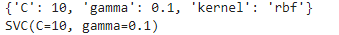

In [ ]:
#Cross Validation
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

weight = {0:(1/6), 1:1}
models = [SVC(C=10, gamma=0.1,kernel='rbf',class_weight=weight)]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features_train, labels, scoring='f1_macro', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1_macro'])

In [ ]:
mean_f1 = cv_df.groupby('model_name').f1_macro.mean()
std_f1 = cv_df.groupby('model_name').f1_macro.std()

f1 = pd.concat([mean_f1, std_f1], axis= 1, 
          ignore_index=True)
f1.columns = ['Mean F1_Macro', 'Standard deviation']
f1

,Mean F1_Macro,Standard deviation
model_name,,
SVC,0.957419,0.00453


In [ ]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features_train, labels, test_size=0.2, random_state=123)

In [ ]:
#Result (Classification Report)
model = models[0].fit(X_train,y_train)
prediction_ = model.predict(features_train)
target_names = ['Ham','Spam']
print(classification_report(labels, prediction_, target_names=target_names))

              precision    recall  f1-score   support

         Ham       1.00      0.99      0.99      4825
        Spam       0.95      0.97      0.96       747

    accuracy                           0.99      5572
   macro avg       0.97      0.98      0.98      5572
weighted avg       0.99      0.99      0.99      5572



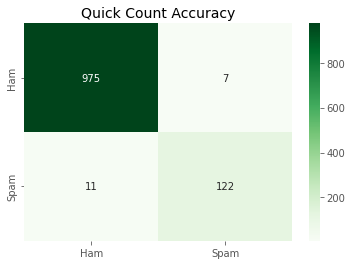

In [ ]:
#Result (Confusion Matric)
import seaborn as sn
confusion_mtx = confusion_matrix(y_test, prediction_)

ax = plt.axes()
sn.heatmap(confusion_mtx, annot=True,ax=ax, cmap=plt.cm.Greens,fmt="d")
ax.set_title('Quick Count Accuracy', size=14)
ax.set_xticklabels(target_names)
ax.set_yticklabels(target_names)
plt.show()

#5. Input-output Model

In [ ]:
def svm_sc(text):
  text = Clean(text)
  print("clean: " + text) 

  text = spell(text)
  print("spell: " +text) 

  text = nltk.word_tokenize(text)
  text = remove_stopwords(text)
  print("stopword remove: " +text) 

  text = del_one_char(text)
  print("del_one_char: " +text) 

  nltk_tokens = nltk.word_tokenize(text)

  word=[]
  for w in nltk_tokens:
      word.append(lemmatizer.lemmatize(w))
  text = TreebankWordDetokenizer().detokenize(word)
  print("Lemmatization: "+text) 

  text = [text]
  text = tfidf.transform(text).toarray()

  predict = model.predict(text)

  if predict == 1 :
    output = "Spam"
  if predict == 0 :
    output = "Ham"
  return print("Text tersebut termasuk " + output)

In [ ]:
text1 = "Halo, hw are u today, i hope u re OK :)"
svm_sc(text1)

clean: halo hw are u today i hope u re ok
spell: halo hw are u today i hope u re ok
stopword remove: halo hw u today hope u ok
del_one_char: halo hw today hope ok
Lemmatization: halo hw today hope ok
Text tersebut termasuk Ham


In [ ]:
text2 = 'URGENT Your grandson was arrested last night in Mexico. Need bail money immediately Western Union Wire $9,500 http://goo.gl/ndf4g5'
svm_sc(text2)

clean: urgent your grandson was arrested last night in mexico need bail money immediately western union wire http goo gl ndf g
spell: urgent your grandson was arrested last night in mexico need bail money immediately western union wire http goo gl df g
stopword remove: urgent grandson arrested last night mexico need bail money immediately western union wire http goo gl df g
del_one_char: urgent grandson arrested last night mexico need bail money immediately western union wire http goo gl df
Lemmatization: urgent grandson arrested last night mexico need bail money immediately western union wire http goo gl df
Text tersebut termasuk Spam
